In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import scipy.stats as stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE

pd.set_option('future.no_silent_downcasting', True)

# Import Data

In [2]:
df_og = pd.read_csv('data/df_combo.csv', index_col=0) # no standardisation, but categories combined

cont_cols = []
cat_cols = [col for col in df_og.columns if df_og[col].dtype=='object']

for col in df_og.columns:
    if ((df_og[col].dtype=="object") or (len(df_og[col].unique())<5)):
        if (df_og[col].dtype!="object"):
            cat_cols.append(col)
    else:
        cont_cols.append(col)

un_log_cols = ['age', 'Total_income', 'Years_employed']

log_cols = cont_cols.copy()

for col in un_log_cols:
    log_cols.append(f'log_{col}')
    log_cols.remove(col)

In [3]:
df = pd.read_csv('data/df_stand2.csv', index_col=0) # preprocessed and standardised data
df.head()

,Exited,gender,age,term_deposit,Own_car,Own_property,credit_score,tenure,balance,Unemployed,...,Family_status_Widow,Housing_type_House/Apartment,Housing_type_Rented or Social Housing,Housing_type_With parents,Occupation_type_High-skill,Occupation_type_Low-skill,Occupation_type_Other,log_age,log_Total_income,log_Years_employed
ID,,,,,,,,,,,,,,,,,,,,,
5008804,1,1,0.291924,0,1,1,-0.324265,-1.040811,-1.222766,0,...,False,False,True,False,False,False,True,3.761200,12.965712,2.597906
5008806,0,1,0.196638,0,1,1,-0.437972,-1.386822,0.120305,0,...,False,True,False,False,False,True,False,3.737670,11.630717,1.412154
5008808,1,1,0.291924,0,0,1,-1.533701,1.035252,1.335893,0,...,False,True,False,False,False,True,False,3.761200,12.506181,2.235735
5008812,0,1,0.006065,0,0,1,0.502700,-1.386822,-1.222766,1,...,False,True,False,False,False,False,True,3.688879,12.554971,0.000000
5008815,0,1,0.387210,0,1,1,2.063597,-1.040811,0.788620,0,...,False,True,False,False,True,False,False,3.784190,12.506181,1.133159


# Try Models with Selected Features

In [4]:
features = ['log_age', 'log_Years_employed', 'credit_score']
X = df[features]
y = df['Target']

## Logistic Regression

In [5]:
accuracies = []
precisions = []
recalls = []
f1s = []
confusions = []
false_ps = []

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Logistic Regression model
model = LogisticRegression() 
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
conf = confusion_matrix(y_test, y_pred)
confusions.append(conf)
print(conf)

accuracies.append(accuracy_score(y_test, y_pred))
precisions.append(precision_score(y_test, y_pred, zero_division=np.nan))
f1s.append(f1_score(y_test, y_pred))
recalls.append(recall_score(y_test, y_pred))
false_ps.append((conf[0, 1]/(conf[0,0]+conf[0,1])))

# Get coefficients
log_reg_coefficients = pd.DataFrame(model.coef_, columns=X.columns)
print(log_reg_coefficients)

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1659
           1       0.00      0.00      0.00       283

    accuracy                           0.85      1942
   macro avg       0.43      0.50      0.46      1942
weighted avg       0.73      0.85      0.79      1942

[[1659    0]
 [ 283    0]]
    log_age  log_Years_employed  credit_score
0  0.069307            0.014929      0.050679


C:\Users\rata\miniconda3\envs\York_data\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rata\miniconda3\envs\York_data\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rata\miniconda3\envs\York_data\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

## Logistic Regression with Balancing

In [6]:
# Initialize and fit the Logistic Regression model
model = LogisticRegression(class_weight='balanced') # because the target variable is not
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
conf = confusion_matrix(y_test, y_pred)
confusions.append(conf)
print(conf)

accuracies.append(accuracy_score(y_test, y_pred))
precisions.append(precision_score(y_test, y_pred))
f1s.append(f1_score(y_test, y_pred))
recalls.append(recall_score(y_test, y_pred))
false_ps.append((conf[0, 1]/(conf[0,0]+conf[0,1])))

# Get coefficients
log_reg_coefficients = pd.DataFrame(model.coef_, columns=X.columns)
print(log_reg_coefficients)

              precision    recall  f1-score   support

           0       0.85      0.50      0.63      1659
           1       0.15      0.49      0.22       283

    accuracy                           0.50      1942
   macro avg       0.50      0.50      0.43      1942
weighted avg       0.75      0.50      0.57      1942

[[835 824]
 [143 140]]
    log_age  log_Years_employed  credit_score
0  0.066856            0.015951      0.050346


## Logistic Regression with Balancing and SMOTE

In [7]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
conf = confusion_matrix(y_test, y_pred)
confusions.append(conf)
print(conf)

accuracies.append(accuracy_score(y_test, y_pred))
precisions.append(precision_score(y_test, y_pred))
f1s.append(f1_score(y_test, y_pred))
recalls.append(recall_score(y_test, y_pred))
false_ps.append((conf[0, 1]/(conf[0,0]+conf[0,1])))

# Get coefficients
log_reg_smote_coefficients = pd.DataFrame(model.coef_, columns=X.columns)
print(log_reg_smote_coefficients)

              precision    recall  f1-score   support

           0       0.85      0.52      0.64      1659
           1       0.14      0.46      0.22       283

    accuracy                           0.51      1942
   macro avg       0.50      0.49      0.43      1942
weighted avg       0.75      0.51      0.58      1942

[[861 798]
 [152 131]]
    log_age  log_Years_employed  credit_score
0  0.103314            0.012474      0.030381


## Random Forest 

In [8]:
# Fit the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
conf = confusion_matrix(y_test, y_pred)
confusions.append(conf)
print(conf)

accuracies.append(accuracy_score(y_test, y_pred))
precisions.append(precision_score(y_test, y_pred))
f1s.append(f1_score(y_test, y_pred))
recalls.append(recall_score(y_test, y_pred))
false_ps.append((conf[0, 1]/(conf[0,0]+conf[0,1])))

# Get feature importances
rf_importances = rf_model.feature_importances_
rf_importances = pd.DataFrame(rf_importances, index=X.columns, columns=["Importance"])
print(rf_importances)

              precision    recall  f1-score   support

           0       0.85      0.99      0.92      1659
           1       0.18      0.02      0.03       283

    accuracy                           0.85      1942
   macro avg       0.52      0.50      0.47      1942
weighted avg       0.76      0.85      0.79      1942

[[1636   23]
 [ 278    5]]
                    Importance
log_age               0.198056
log_Years_employed    0.395971
credit_score          0.405973


## Random Forest with Balancing

In [9]:
# Fit the Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
conf = confusion_matrix(y_test, y_pred)
confusions.append(conf)
print(conf)

accuracies.append(accuracy_score(y_test, y_pred))
precisions.append(precision_score(y_test, y_pred))
f1s.append(f1_score(y_test, y_pred))
recalls.append(recall_score(y_test, y_pred))
false_ps.append((conf[0, 1]/(conf[0,0]+conf[0,1])))

# Get feature importances
rf_importances = rf_model.feature_importances_
rf_importances = pd.DataFrame(rf_importances, index=X.columns, columns=["Importance"])
print(rf_importances)

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1659
           1       0.16      0.02      0.03       283

    accuracy                           0.84      1942
   macro avg       0.51      0.50      0.47      1942
weighted avg       0.75      0.84      0.79      1942

[[1632   27]
 [ 278    5]]
                    Importance
log_age               0.226513
log_Years_employed    0.368783
credit_score          0.404704


## Random Forest with Balancing and SMOTE

In [10]:
rf_model.fit(X_train_resampled, y_train_resampled)

# Predictions and evaluation
y_pred = rf_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
conf = confusion_matrix(y_test, y_pred)
confusions.append(conf)
print(conf)

accuracies.append(accuracy_score(y_test, y_pred))
precisions.append(precision_score(y_test, y_pred))
f1s.append(f1_score(y_test, y_pred))
recalls.append(recall_score(y_test, y_pred))
false_ps.append((conf[0, 1]/(conf[0,0]+conf[0,1])))

# Get feature importances
rf_smote_importances = rf_model.feature_importances_
rf_smote_importances = pd.DataFrame(rf_importances, index=X.columns, columns=["Importance"])
print(rf_smote_importances)

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1659
           1       0.14      0.14      0.14       283

    accuracy                           0.75      1942
   macro avg       0.50      0.50      0.50      1942
weighted avg       0.75      0.75      0.75      1942

[[1425  234]
 [ 244   39]]
                    Importance
log_age               0.226513
log_Years_employed    0.368783
credit_score          0.404704


# Evaluate Models

In [11]:
models = ['Logistic Regression', 'Balanced Logistic Regression', 'SMOTE + Balanced Logistic Regression',
          'Random Forest', 'Balanced Random Forest', 'SMOTE + Balanced Random Forest']

In [12]:
scores = np.array([accuracies, precisions, recalls, f1s, false_ps]).T
df_scores = pd.DataFrame(scores, columns=['Accuracy', 'Precision', 'Recall', 'F1', 'False Positive Rate'], index=models)
df_scores

,Accuracy,Precision,Recall,F1,False Positive Rate
Logistic Regression,0.854274,NaN,0.000000,0.000000,0.000000
Balanced Logistic Regression,0.502060,0.145228,0.494700,0.224539,0.496685
SMOTE + Balanced Logistic Regression,0.510814,0.141012,0.462898,0.216172,0.481013
Random Forest,0.845005,0.178571,0.017668,0.032154,0.013864
Balanced Random Forest,0.842945,0.156250,0.017668,0.031746,0.016275
SMOTE + Balanced Random Forest,0.753862,0.142857,0.137809,0.140288,0.141049


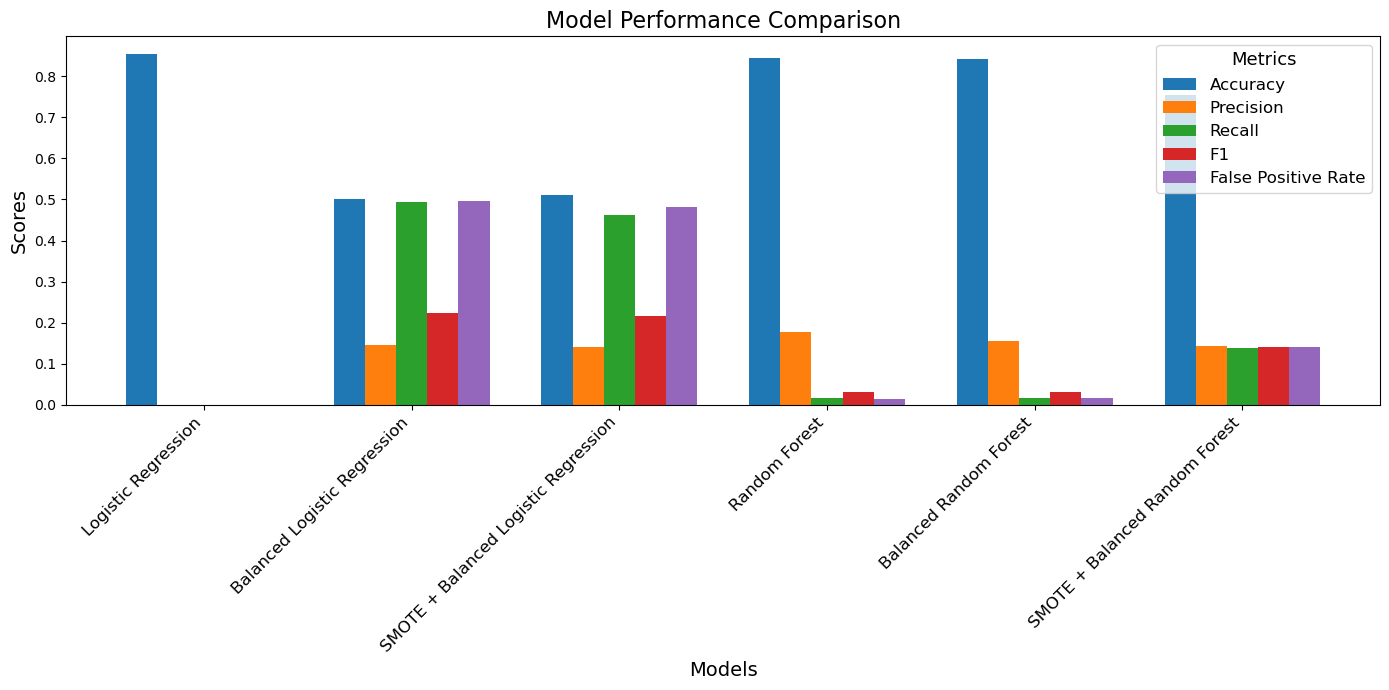

In [13]:
bar_width = 0.15  # Width of each bar
model_indices = np.arange(len(df_scores.index))  # Indices for each model

# Set figure size
plt.figure(figsize=(14, 7))

# Create bars for each metric
for i, column in enumerate(df_scores.columns):
    plt.bar(model_indices + (i - 2) * bar_width, df_scores[column], width=bar_width, label=column)

# Add labels and title
plt.xlabel('Models', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Model Performance Comparison', fontsize=16)

# Add x-ticks for model names
plt.xticks(model_indices, df_scores.index, fontsize=12, rotation=45, ha='right')

# Create legend
plt.legend(title='Metrics', fontsize=12, title_fontsize='13')

# Adjust layout to prevent clipping
plt.tight_layout()
plt.show()